<a href="https://colab.research.google.com/github/Murcha1990/ML_AI25/blob/main/Hometasks/Pro/AI_HW1_Regression_with_inference_pro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Домашнее задание №1 (pro). Часть 1**

В этом домашнем задании (его первой части) вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;


> Оценка за первую часть домашки = $min(\text{ваш балл}, 7)$



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [84]:
!pip install ydata_profiling

In [85]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from IPython.display import display
from ydata_profiling import ProfileReport
from scipy.stats import chi2_contingency, f_oneway
from scipy import sparse
import re
from sklearn.linear_model import LinearRegression, LassoCV, Ridge, ElasticNet, OrthogonalMatchingPursuit, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import phik

MSE = mean_squared_error

random.seed(42)
np.random.seed(42)


### **Задание 0**
Давайте зафиксируем важный момент.

**Задание 0 (0 баллов).**
Изучите и ответье на вопрос: для чего фиксируем сиды в домашках?

Сиды фиксируем для воспроизводимости (Повторяемости) результатов


# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [86]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Размер train:", df_train.shape)
print("Размер test:", df_test.shape)

Размер train: (6999, 13)
Размер test: (1000, 13)


### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [ ] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [ ] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [ ] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [ ] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла).


In [87]:
missing_train = df_train.isna().sum()
missing_test = df_test.isna().sum()

print("Колонки в трейне с пропусками (явными):")
print(missing_train[missing_train > 0])

print("\nКолонки в тесте с пропусками (явными):")
print(missing_test[missing_test > 0])


Колонки в трейне с пропусками (явными):
mileage      202
engine       202
max_power    196
torque       203
seats        202
dtype: int64

Колонки в тесте с пропусками (явными):
mileage      19
engine       19
max_power    19
torque       19
seats        19
dtype: int64


В трейне пропуски только в `mileage`, `engine`, `max_power`, `torque`, `seats` (~196–203 строк для каждого столбца). В тесте эти же пять колонок имеют по 19 пропусков.

Полных дубликатов: 985 из 6999 строк в train и 62 из 1000 строк в test — их удалю перед обучением.


In [88]:
train_dups = df_train.duplicated().sum()
test_dups = df_test.duplicated().sum()

print(f"Повторы в трейне: {train_dups} ({train_dups / len(df_train):.1%})")
print(f"Повторы в тесте: {test_dups} ({test_dups / len(df_test):.1%})")


Повторы в трейне: 985 (14.1%)
Повторы в тесте: 62 (6.2%)


In [89]:
profile = ProfileReport(df_train, title="Тренировочная дата", minimal=True, explorative=True)
profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 11678.29it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

- Цена (`selling_price`) и пробег (`km_driven`) имеют сильную правую асимметрию с выбросами.
- Годы выпуска сконцентрированы в диапозоне 2010–2020.
- Категориальные признаки `fuel` несбалансрованы: ~99% машин испольузуют как топливо в основном Diesel/Petrol.Также 87% машин являются Механикой.
- Признаки `mileage`, `engine`, `max_power`, `torque` содержат единицы измерения в строках, из-за чего признаки являются не колонкой чисел.

### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [ ] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?
- [ ] Сделайте выводы по статистикам. Отсутсвие выводов равносильно по баллам невыполнению задания.

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

In [90]:
num_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df_train.select_dtypes(exclude=[np.number]).columns.tolist()

train_num_stats = df_train[num_cols].describe().T
test_num_stats = df_test[num_cols].describe().T

train_cat_stats = df_train[cat_cols].describe()
test_cat_stats = df_test[cat_cols].describe()

mean_median_df = pd.DataFrame({
    'train_mean': df_train[num_cols].mean(),
    'train_median': df_train[num_cols].median(),
    'test_mean': df_test[num_cols].mean(),
    'test_median': df_test[num_cols].median(),
    'train_mean_minus_median': df_train[num_cols].mean() - df_train[num_cols].median(),
    'test_mean_minus_median': df_test[num_cols].mean() - df_test[num_cols].median(),
})

print('Числовые признаки:')
display(train_num_stats, test_num_stats)
print('Категориальные признаки:')
display(train_cat_stats, test_cat_stats)
print('Сравнение среднего и медианы:')
display(mean_median_df.T)


Числовые признаки:


count           mean  ...       75%         max
year           6999.0    2013.818403  ...    2017.0      2020.0
selling_price  6999.0  639515.197171  ...  675000.0  10000000.0
km_driven      6999.0   69584.615517  ...   97000.0   2360457.0
seats          6797.0       5.419008  ...       5.0        14.0

[4 rows x 8 columns]

count           mean  ...       75%        max
year           1000.0    2013.681000  ...    2017.0     2020.0
selling_price  1000.0  617901.042000  ...  670000.0  6000000.0
km_driven      1000.0   71393.341000  ...  100000.0   375000.0
seats           981.0       5.410805  ...       5.0        9.0

[4 rows x 8 columns]

Категориальные признаки:


name    fuel  ... max_power          torque
count                     6999    6999  ...      6803            6796
unique                    1924       4  ...       316             419
top     Maruti Swift Dzire VDI  Diesel  ...    74 bhp  190Nm@ 2000rpm
freq                       116    3793  ...       330             468

[4 rows x 9 columns]

name    fuel  ... max_power          torque
count                  1000    1000  ...       981             981
unique                  621       4  ...       182             226
top     Maruti Alto 800 LXI  Diesel  ...    74 bhp  200Nm@ 1750rpm
freq                     15     534  ...        43              57

[4 rows x 9 columns]

Сравнение среднего и медианы:


year  selling_price     km_driven     seats
train_mean               2013.818403  639515.197171  69584.615517  5.419008
train_median             2015.000000  450000.000000  60000.000000  5.000000
test_mean                2013.681000  617901.042000  71393.341000  5.410805
test_median              2014.000000  434999.000000  61500.000000  5.000000
train_mean_minus_median    -1.181597  189515.197171   9584.615517  0.419008
test_mean_minus_median     -0.319000  182902.042000   9893.341000  0.410805

- Среднее сильно превышает медиану для `selling_price` и `km_driven`, скорее всего есть правый перекос и выбросы. Медиана тут будет более репрезентативна, чем среднее.
- По `year` среднее и медиана почти совпадают, тест немного смещён к более старым авто.
- Как уже отмечалось ранее: категориальные признаки несбалансированы. 86% механика, топливо в основном Diesel/Petrol, продавцы чаще `Individual`.
- Распределения признаков в train/test сопоставимы, явных перекосов в датасетах не видно, но отличия в наиболее частых значениях категорий (`name`) возможны.


### **Задание 3 (0.2 балла)**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.01 балла)
- [ ] Отобразите такие объекты (0.01 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.01 балла)
- [ ]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.01 балла)
- [ ] Подумайте, могут ли в данных быть другие скрытые дубли? Предложите, как их можно отлавливать. (0.16 балла)

P.S тут данные без подвоха, но выводы нам нужны.

In [91]:
feature_cols = [c for c in df_train.columns if c != "selling_price"]
dup_mask = df_train.duplicated(subset=feature_cols, keep=False)

dup_count = dup_mask.sum()
dup_examples = df_train.loc[dup_mask].sort_values(feature_cols).head(7)

print(f'Строки с повторами: {dup_count}')
display(dup_examples)


Строки с повторами: 1799


name  year  ...               torque  seats
1703  Audi Q3 2.0 TDI Quattro Premium Plus  2017  ...  380Nm@ 1750-2500rpm    5.0
6307  Audi Q3 2.0 TDI Quattro Premium Plus  2017  ...  380Nm@ 1750-2500rpm    5.0
1836               Audi Q5 3.0 TDI Quattro  2014  ...  580Nm@ 1400-3250rpm    5.0
6704               Audi Q5 3.0 TDI Quattro  2014  ...  580Nm@ 1400-3250rpm    5.0
117             Audi Q5 35TDI Premium Plus  2018  ...  400nm@ 1750-3000rpm    5.0
1337            Audi Q5 35TDI Premium Plus  2018  ...  400nm@ 1750-3000rpm    5.0
1595            Audi Q5 35TDI Premium Plus  2018  ...  400nm@ 1750-3000rpm    5.0

[7 rows x 13 columns]

In [92]:
price_conflicts = (df_train.groupby(feature_cols)['selling_price'].nunique().reset_index(name='price_versions'))
price_conflicts = price_conflicts[price_conflicts['price_versions'] > 1]
print(f'Строк с одинаковыми фичами но разными ценами: {len(price_conflicts)}')
display(price_conflicts.head())


Строк с одинаковыми фичами но разными ценами: 160


name  year  ...  seats price_versions
68      BMW X4 M Sport X xDrive20d  2019  ...    5.0              2
90        Chevrolet Beat Diesel LT  2012  ...    5.0              3
148  Chevrolet Enjoy 1.3 TCDi LS 8  2016  ...    8.0              2
207         Chevrolet Spark 1.0 LS  2010  ...    5.0              2
302     Datsun RediGO 1.0 T Option  2017  ...    5.0              2

[5 rows x 13 columns]

In [93]:
df_train = df_train.drop_duplicates(subset=feature_cols, keep='first').reset_index(drop=True)
print('Шейп фрейма после удаления колонок:', df_train.shape)


Шейп фрейма после удаления колонок: (5840, 13)


Возможны скрытые дубли, которые  можно искать после нормализации строк (нижний регистр, удаление пробелов, единиц измерения) и округления числовых признаков. Я думаю стоит:
- очистить текстовые поля `name`, удалить спецсимволы и сравнить на наличие совпадений
- нормализовать числове колоноки и сравнить после округления и нормализации единиц (привести все к км как пример)
- использовать кластеризацию или другие методы для поиска почти совпадающих названий моделей.


### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

In [94]:

numeric_text_cols = ['mileage', 'engine', 'max_power']

def to_float(series):
    return series.astype(str).str.extract(r'([\d\.]+)', expand=False).astype(float)

for col in numeric_text_cols:
    df_train[col] = to_float(df_train[col])
    df_test[col] = to_float(df_test[col])

def parse_torque(series):
    def convert(val):
        if pd.isna(val):
            return pd.Series({'torque': None, 'max_torque_rpm': None})
        s = str(val).lower().replace(',', '')
        numbers = re.findall(r'[0-9]+\.?[0-9]*', s)
        if not numbers:
            return pd.Series({'torque': None, 'max_torque_rpm': None})
        torque_val = float(numbers[0])
        if 'kgm' in s:
            torque_val *= 9.80665  # перевод кгм в нм по формуле из интернетов
        rpm_vals = [float(n) for n in numbers[1:]]
        rpm_val = sum(rpm_vals) / len(rpm_vals) if rpm_vals else None
        return pd.Series({'torque': torque_val, 'max_torque_rpm': rpm_val})
    parsed = series.apply(convert)
    return parsed['torque'], parsed['max_torque_rpm']

df_train['torque'], df_train['max_torque_rpm'] = parse_torque(df_train['torque'])
df_test['torque'], df_test['max_torque_rpm'] = parse_torque(df_test['torque'])

display(df_train[['mileage', 'engine', 'max_power', 'torque', 'max_torque_rpm']].head(20))


mileage  engine  max_power      torque  max_torque_rpm
0     23.40  1248.0      74.00  190.000000          2000.0
1     21.14  1498.0     103.52  250.000000          2000.0
2     23.00  1396.0      90.00  219.668960          2250.0
3     16.10  1298.0      88.20  112.776475          4500.0
4     20.14  1197.0      81.86  113.750000          4000.0
5     17.30  1061.0      57.50   76.491870          4500.0
6     16.10   796.0      37.00   59.000000          2500.0
7     23.59  1364.0      67.10  170.000000          2100.0
8     20.00  1399.0      68.10  160.000000          2000.0
9     19.01  1461.0     108.45  248.000000          2250.0
10    17.30   993.0      60.00   78.000000          4500.0
11    19.30  1248.0      73.90  190.000000          2000.0
12      NaN     NaN        NaN         NaN             NaN
13    18.90  1061.0      67.00   84.000000          3500.0
14    18.15  1198.0      82.00  115.000000          3550.0
15    23.00  1396.0      90.00  219.668960          2250.0
16    19.70   796.0      46.30   62.000000          3000.0
17    22.54  1396.0      88.73  219.700000          2125.0
18    21.00  1461.0      64.10  160.000000          2000.0
19    25.50  1498.0      98.60  200.000000          1750.0

### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [ ] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [ ] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - По тренировочным данным для `train` и `test`






In [95]:
input_cols = ['mileage', 'engine', 'max_power', 'torque', 'max_torque_rpm', 'seats']
train_medians = df_train[input_cols].median()

df_train[input_cols] = df_train[input_cols].fillna(train_medians)
df_test[input_cols] = df_test[input_cols ].fillna(train_medians)

print('Пропуски в train после заполнения:', df_train[input_cols].isna().sum())
print('\nПропуски в test после заполнения:', df_test[input_cols].isna().sum())


Пропуски в train после заполнения: mileage           0
engine            0
max_power         0
torque            0
max_torque_rpm    0
seats             0
dtype: int64

Пропуски в test после заполнения: mileage           0
engine            0
max_power         0
torque            0
max_torque_rpm    0
seats             0
dtype: int64


__Комментарии:__ Мы используем медиану, а не среднее так как она более устойчива к выбросам и величины меньше/больше в сотни раз чем наши средние значения при удалении их величин не так сильно влияют на медиану, как на это самое среднее. 
Правильным будет использовать общую медиану из трейна. Иначе после слияния будет утчека информации из теста в обучение (при использовании тестовой), либо нарушение реалистичности модели, если возьмум для теста - тестовую. Ибо из-за более низкого кол-ва строк пограничные значения и выбросы аффектят тестовый датасет куда сильнее чем обучающий.

### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.
- [ ] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [96]:
df_train['engine'] = df_train['engine'].astype(int)
df_test['engine'] = df_test['engine'].astype(int)
df_train['seats'] = df_train['seats'].astype(int)
df_test['seats'] = df_test['seats'].astype(int)

print(df_train[['engine', 'seats']].dtypes, '\n\n', df_test[['engine', 'seats']].dtypes)


engine    int64
seats     int64
dtype: object 

 engine    int64
seats     int64
dtype: object


`seats` принимает небольшое число значений (2, 4, 5, 7...), фактически отражает категорию типа автомобиля по кузову, поэтому его можно рассматривать как категориальный признак.


### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [ ] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [97]:
post_fill_stats = df_train.select_dtypes(include=[np.number]).describe().T
display(post_fill_stats)


count           mean  ...           75%           max
year            5840.0    2013.428425  ...    2017.00000  2.020000e+03
selling_price   5840.0  522960.091096  ...  640000.00000  1.000000e+07
km_driven       5840.0   73952.242466  ...  100000.00000  2.360457e+06
mileage         5840.0      19.430841  ...      22.30000  4.200000e+01
engine          5840.0    1429.448973  ...    1498.00000  3.604000e+03
max_power       5840.0      87.906371  ...      99.00000  4.000000e+02
torque          5840.0     175.930478  ...     200.05566  3.726527e+03
seats           5840.0       5.426712  ...       5.00000  1.400000e+01
max_torque_rpm  5840.0    2846.153228  ...    3750.00000  2.180000e+04

[9 rows x 8 columns]

Заполнение медианами почти не сдвинуло распределения: медиана сохраняется, среднее изменилось минимально, т.к. медианой заменяются точечные пропуски.
Сдвиг мог бы возникнуть при действительно большом числе пропусков или при замене их большим средним или выделяющейся константой, которые тянут распределение в сторону границ.


## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [ ] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [ ] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [ ] Постройте pairplot по тестовым данным
- [ ] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

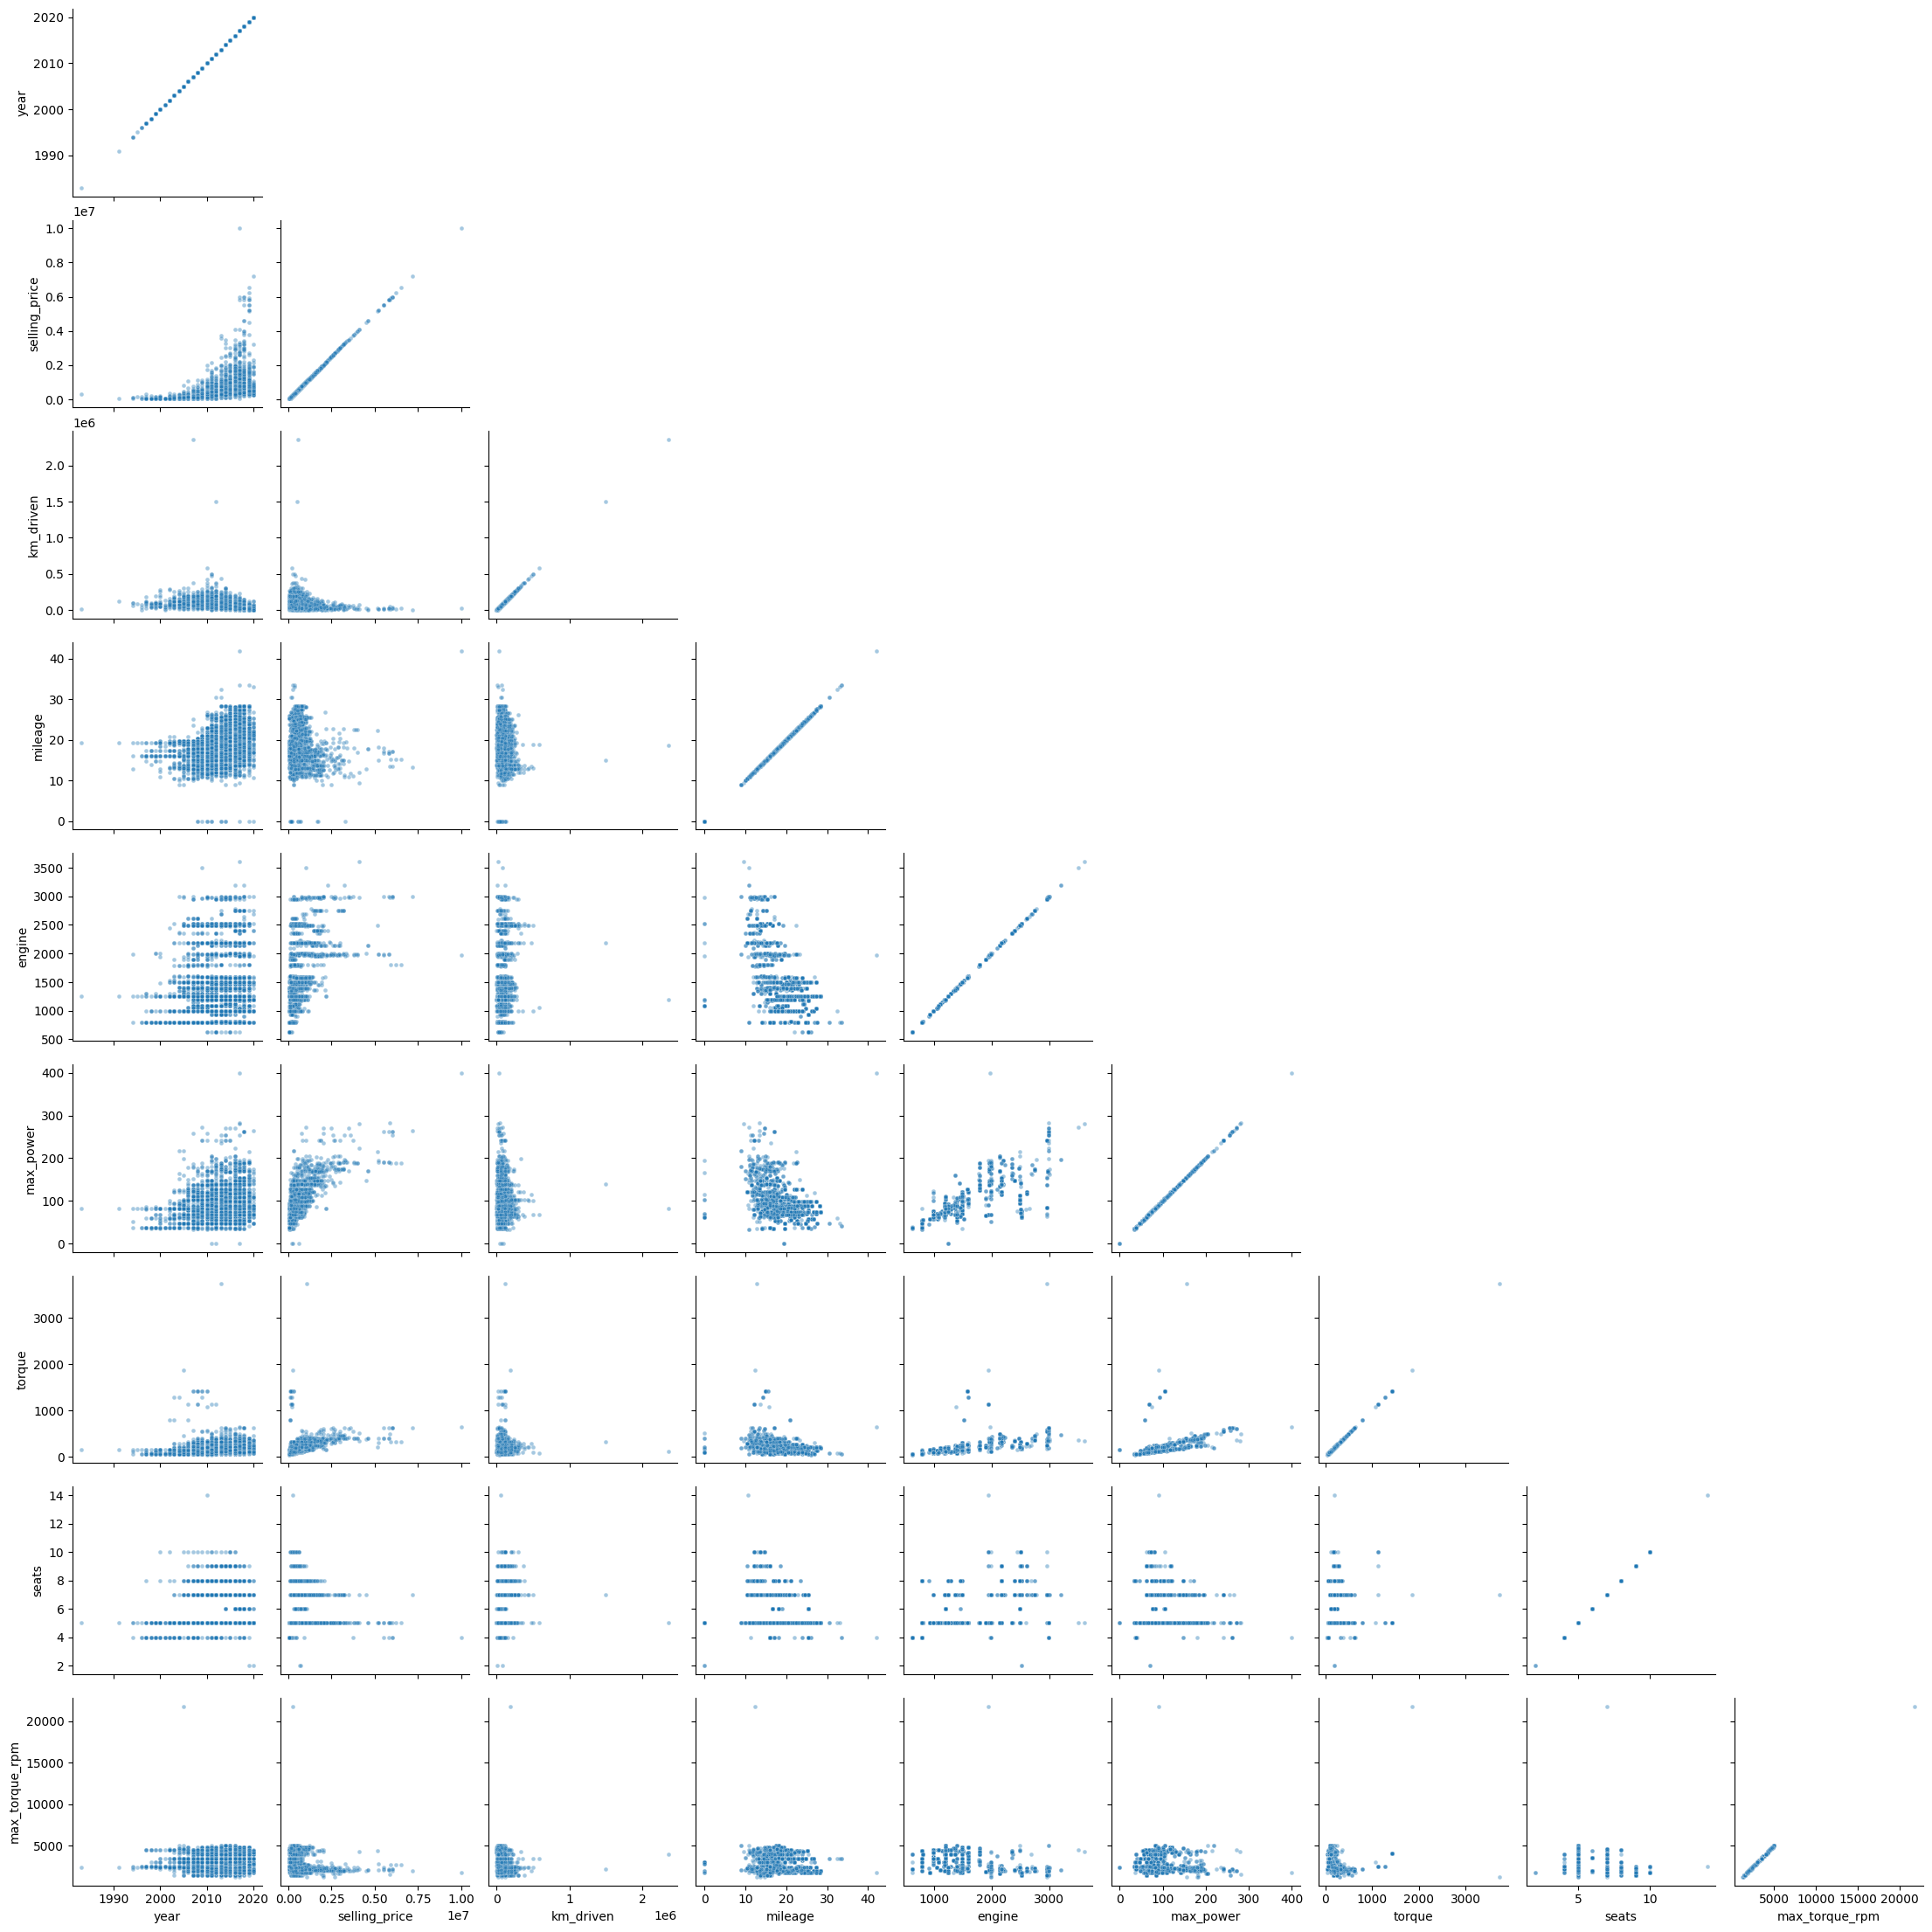

In [98]:
num_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
g = sns.pairplot(
    df_train,
    vars=num_cols,
    diag_kind=None,
    corner=True,
    plot_kws={'alpha':0.4, 's':12}
)
display(g)


__Комментарий__:
- `max_power`, `engine` и частично `year` выглядят связанными с `selling_price` (целевая цен растет вместе с мощностью/объемом и новизной машины)
- Гипотезы по корреляциям: `max_power` и `engine` заметно скоррелированы между собой
- `km_driven` скорее негативно связан с ценой и годом выпуска.

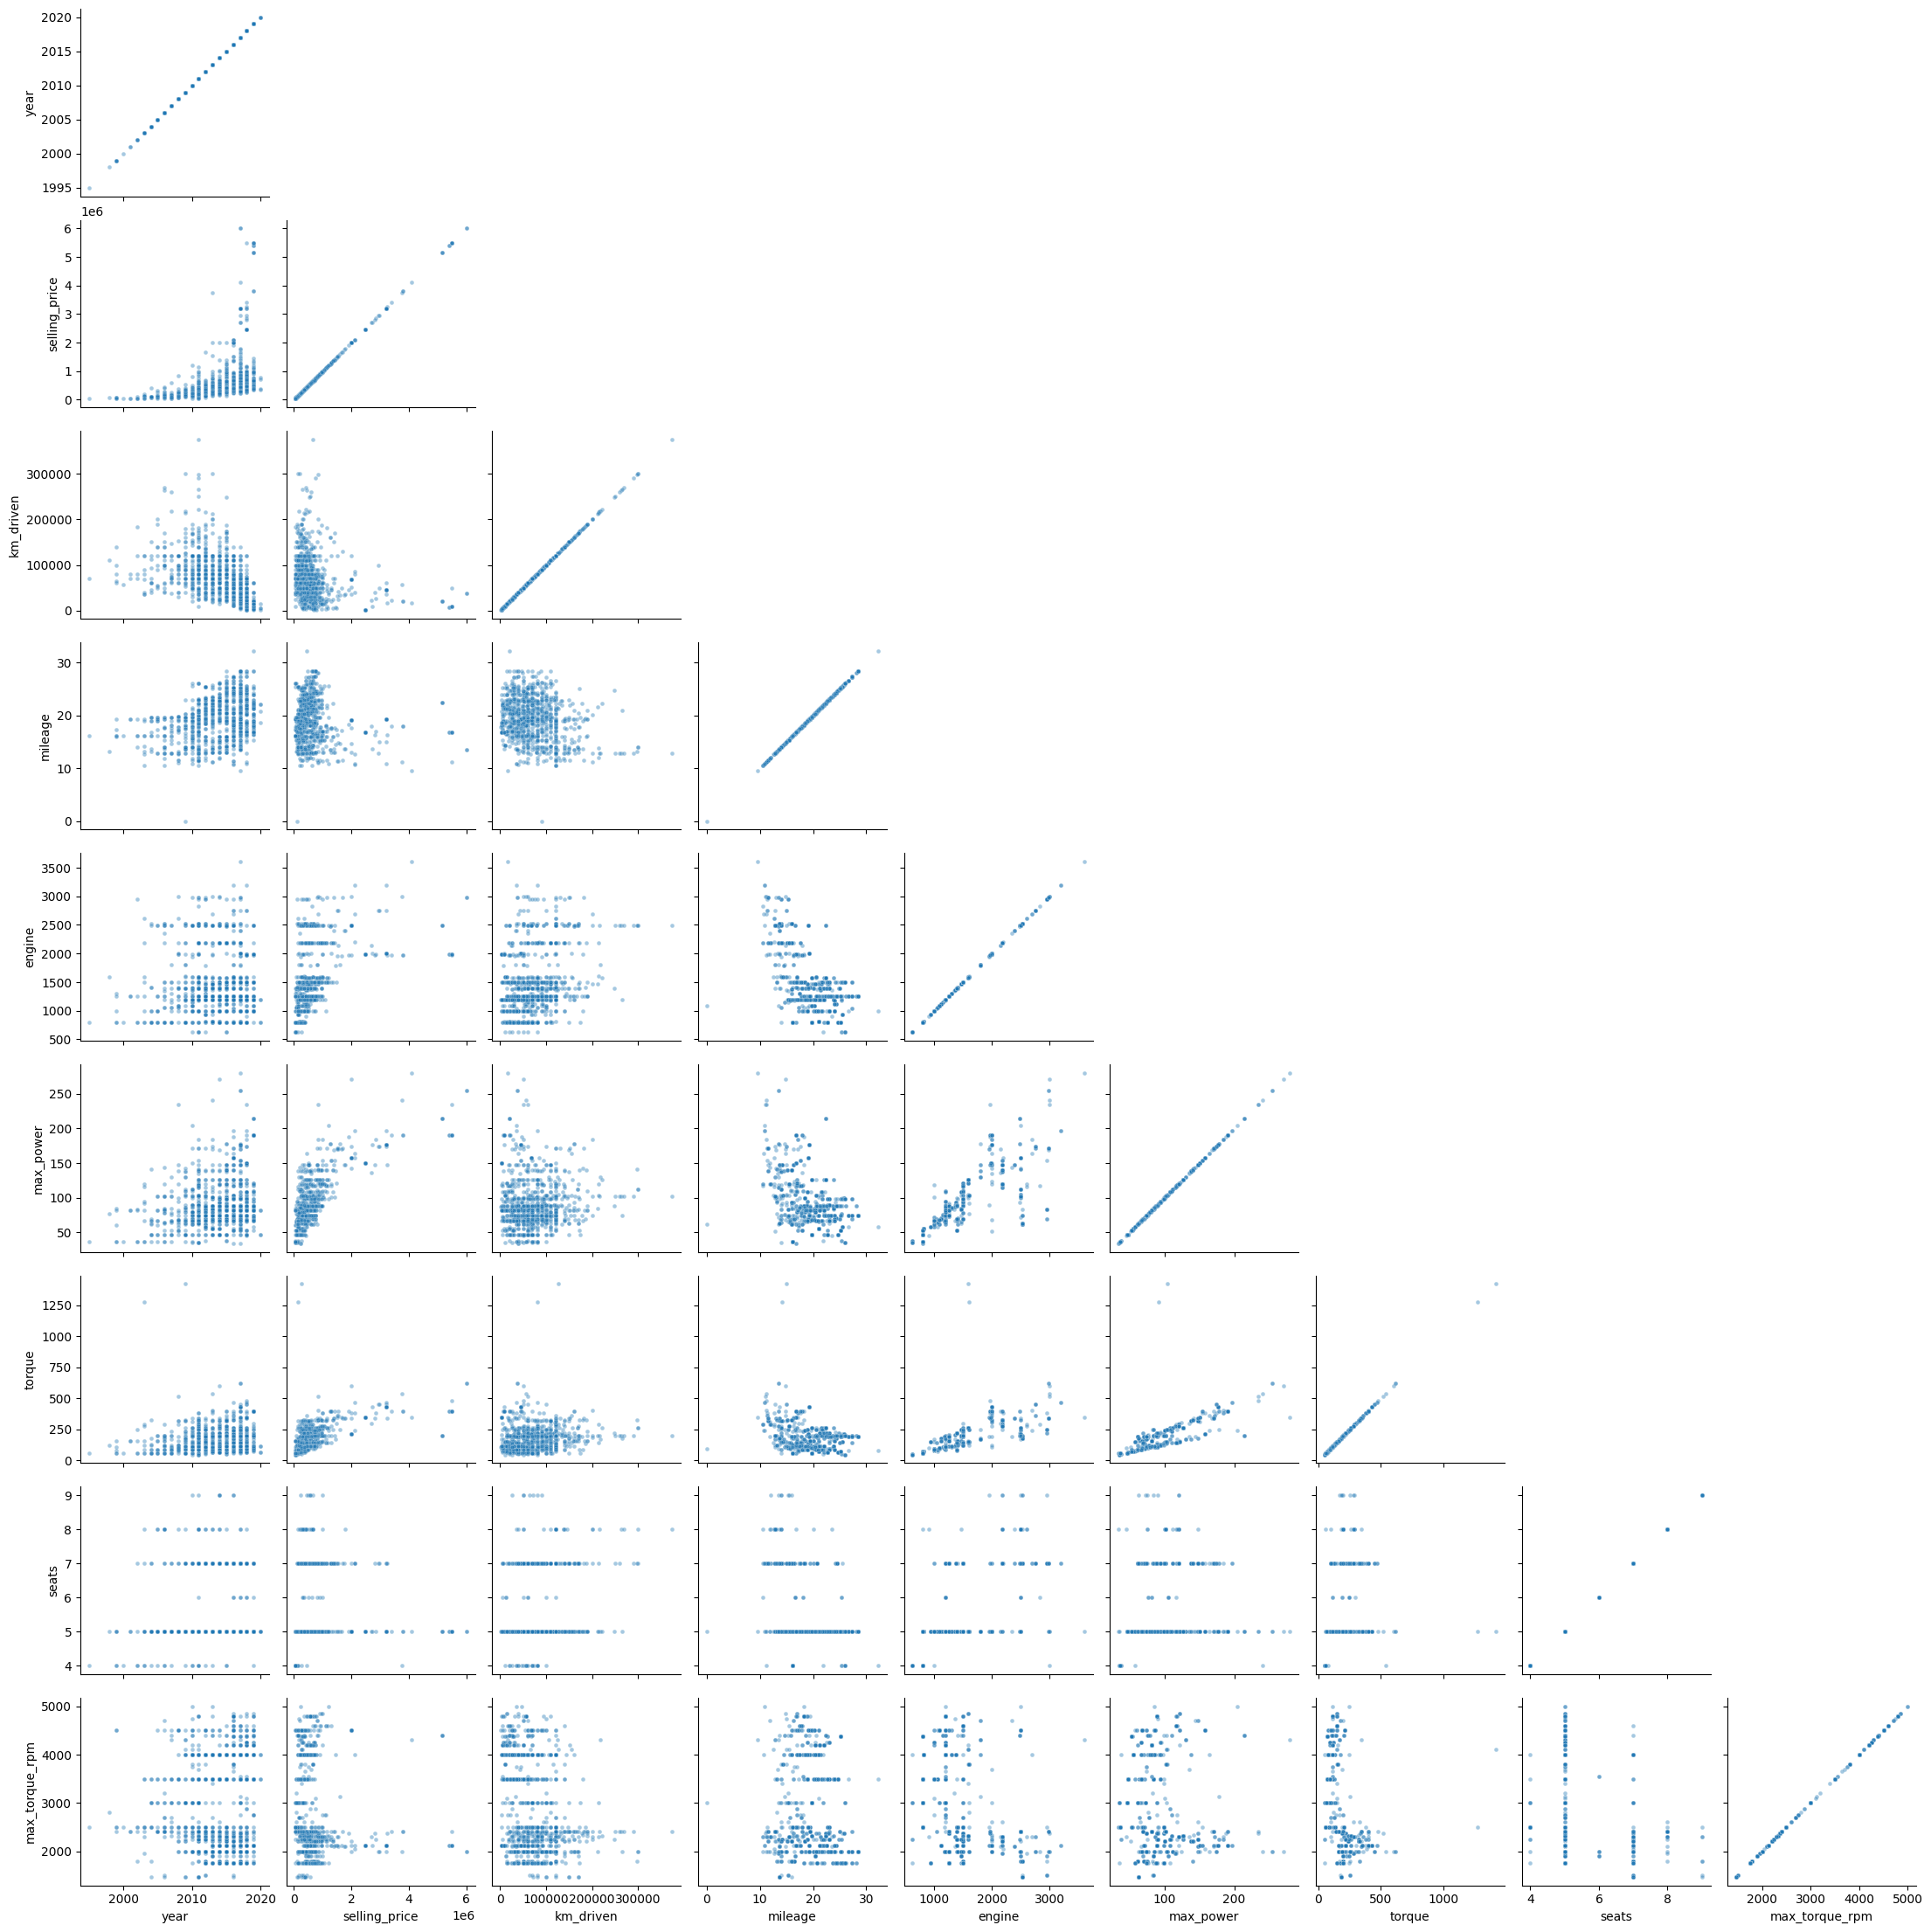

In [99]:
g_test = sns.pairplot(
    df_test,
    vars=num_cols,
    diag_kind=None,
    corner=True,
    plot_kws={'alpha':0.4, 's':12}
)
display(g_test)


__Комментарий по тестовому pairplot (Шаг 2):__
- По pairplot тестовый набор заметно отличается от трейна: облака по ряду пар признаков растянуты, где-то даже смещны. Формы распределений не совпадают, `km_dirven/year` например отличается сильно. А вот `selling_price/year` абсолютно такой же как и в обучающей выборке.
- Скорее всего совокупности не идентичныю.


### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [ ] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [ ] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

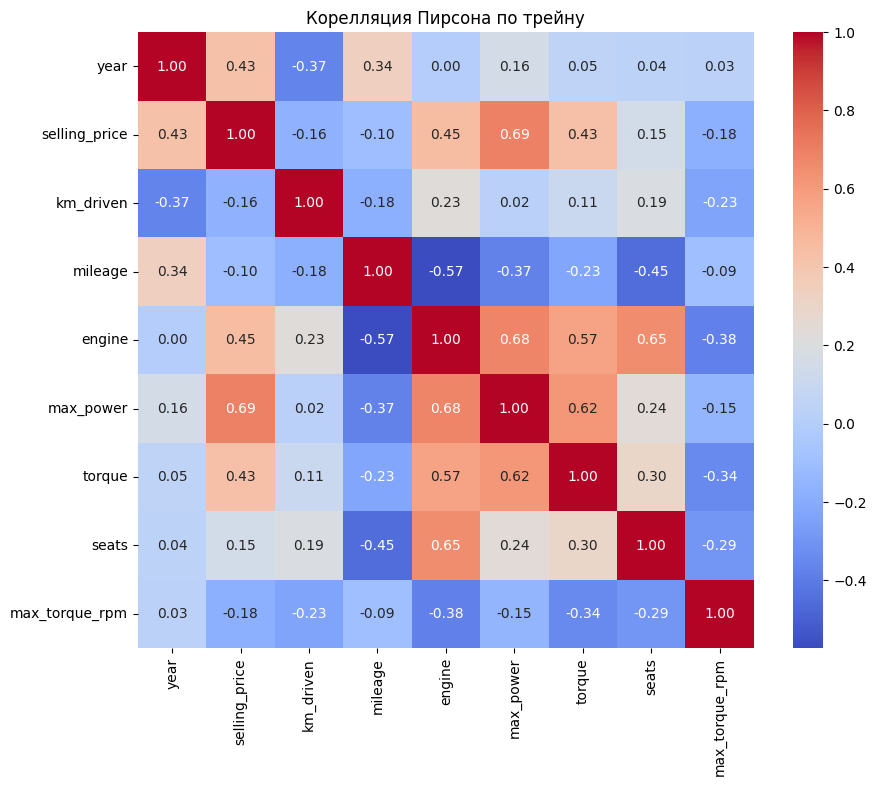

In [100]:
pearson_corr = df_train[num_cols].corr(method='pearson')
plt.figure(figsize=(10, 8))
sns.heatmap(pearson_corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Корелляция Пирсона по трейну')
plt.show()


- [ ] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?
 - Изучите типы корреляций в `pd.corr()`. Какую вы использовали по умолчанию?

Наименее скоррелированы: `engine` и `year` (корреляция примерно 0).
Сильная положительная линейная зависимость: `max_power` и `selling_price` (0.69), также высока связь `max_power` с `engine`, что довольно логично.
Корреляция `year` и `km_driven` -0.37, что подтверждает гипотезу, что меньший год ведет к большему пробегу.
Использована корреляция Пирсона (по умолчанию в `pd.corr`). Также тип кастомный тип `CorrelationMethod` включает в себя корреляции: `kendall`, `spearman`.
]


### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [ ] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией
- [ ] Сделайте выводы


Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [ ] Проинтерпретируйте результаты


Максимальное отличие ручной матрицы и pandas: year              0.0
selling_price     0.0
km_driven         0.0
mileage           0.0
engine            0.0
max_power         0.0
torque            0.0
seats             0.0
max_torque_rpm    0.0
dtype: float64


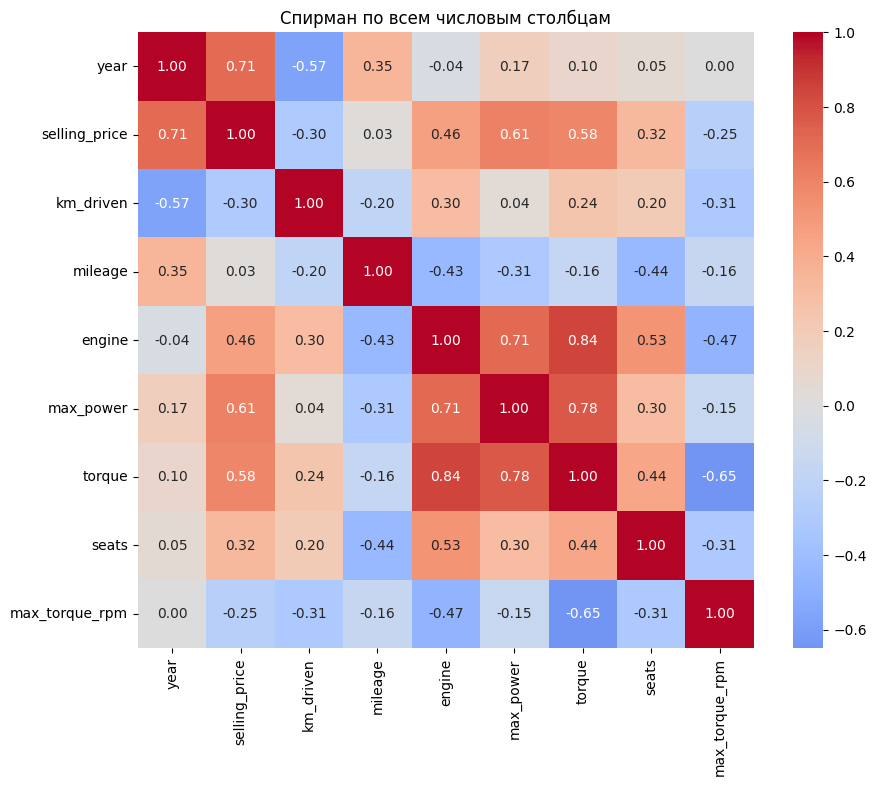

In [101]:
def spearman_correlation(x, y):
    rx = pd.Series(x).rank(method='average').to_numpy()
    ry = pd.Series(y).rank(method='average').to_numpy()
    rx_c = rx - rx.mean()
    ry_c = ry - ry.mean()
    denominator = np.sqrt((rx_c @ rx_c) * (ry_c @ ry_c))
    return (rx_c @ ry_c) / denominator

manual_spearman = pd.DataFrame(index=num_cols, columns=num_cols, dtype=float)
for i, c1 in enumerate(num_cols):
    for j, c2 in enumerate(num_cols):
        if j < i:
            manual_spearman.loc[c1, c2] = manual_spearman.loc[c2, c1]
        else:
            manual_spearman.loc[c1, c2] = spearman_correlation(df_train[c1], df_train[c2])

pandas_spearman = df_train[num_cols].corr(method='spearman')
diff_max = (manual_spearman - pandas_spearman).max()
print(f'Максимальное отличие ручной матрицы и pandas: {diff_max}')

plt.figure(figsize=(10, 8))
sns.heatmap(manual_spearman, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True)
plt.title('Спирман по всем числовым столбцам')
plt.show()


Наша имплменетация матрицы Спирмена совпала с pandas, что подтверждает корректность. На хитмапе видны сильные связи `max_power`–`torque`–`engine`, умеренная отрицательная связь пробега/года. В целом сходе с пирсаном (обший фон), где-то просто корреляции сильнее.


interval columns not set, guessing: ['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm']


/home/iness0/projects/ml-homework/.venv/lib/python3.12/site-packages/phik/data_quality.py:59: UserWarning: The number of unique values of variable name is large: 1924. Are you sure this is not an interval variable? Analysis for pairs of variables including name can be slow.
  warnings.warn(


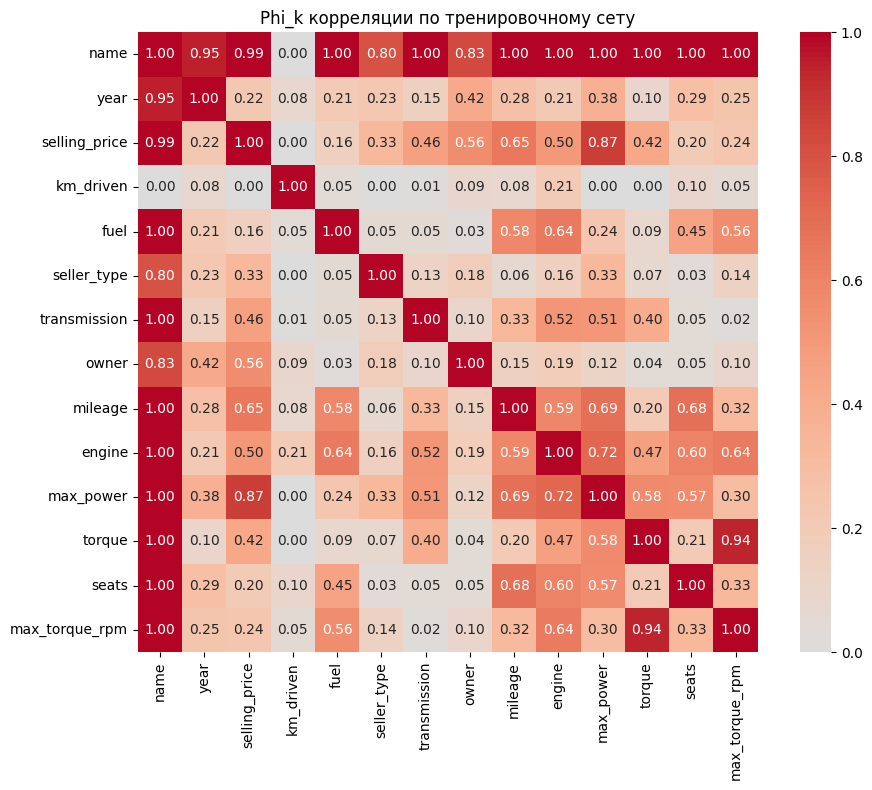

In [102]:
phik_corr = df_train.phik_matrix(interval_cols=None)
plt.figure(figsize=(10, 8))
sns.heatmap(phik_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, square=True)
plt.title('Phi_k корреляции по тренировочному сету')
plt.tight_layout()
plt.show()


Phi_k оценивает ассоциации для числовых и категориальных признаков. Видим новые сильный ассоциации: `torque/max_toruq`, что очень ожидаемо, и выделялось не настолько сильнко на Пирсоне. (хотя спирман указывал отрицательную связь). Связь владельца и цены, которую ранее мы не могли проследить. Типа топлива и макимальной силы двигателя. name, конечно, имеет близкую к единице корреляцию со всеми признаками кроме пробега и типа владельца (тоже сильные) - тк у машины одной модели все характеристики одинраковые, и цена близкая.


### **Дополнительные визуализации (бонус 0.25 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.
Один график: 0.125 балла, при условии, что он обоснован.

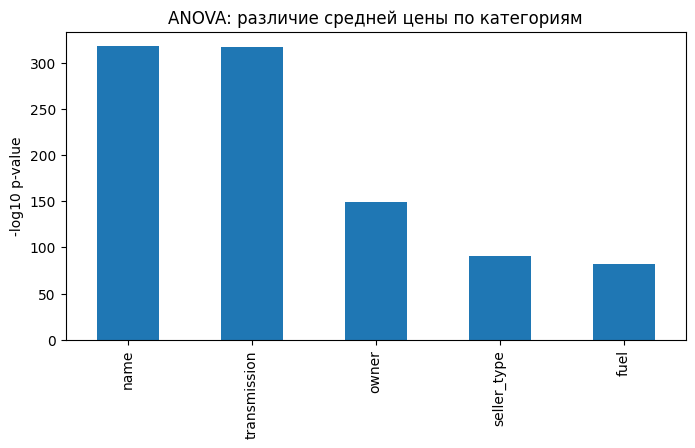

In [103]:
cat_cols = df_train.select_dtypes(exclude=[np.number]).columns
anova_vals = {}
for col in cat_cols:
    groups = [grp['selling_price'].values for _, grp in df_train.groupby(col) if len(grp) > 1]
    if len(groups) > 1:
        stat, pval = f_oneway(*groups)
        anova_vals[col] = pval
    else:
        anova_vals[col] = np.nan

anova_series = pd.Series(anova_vals).dropna().sort_values()

positive = anova_series[anova_series > 0]
eps = positive.min() * 0.1 if not positive.empty else np.nextafter(0, 1)
safe_vals = anova_series.replace(0, eps)

plt.figure(figsize=(8, 4))
(-np.log10(safe_vals)).plot(kind='bar')
plt.ylabel('-log10 p-value')
plt.title('ANOVA: различие средней цены по категориям')
plt.show()

ANOVA проверяет, различаются ли средние цены между категориями. Видим что в `transmission` различия сильные, как и в `name`.


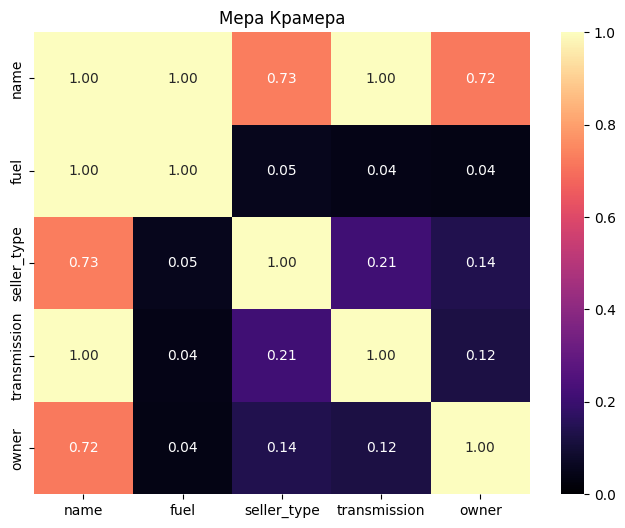

In [104]:
cat_cols = df_train.select_dtypes(exclude=[np.number]).columns
def cramer(confusion):
    chi2 = chi2_contingency(confusion)[0]
    n = confusion.to_numpy().sum()
    r, k = confusion.shape
    return np.sqrt((chi2 / n) / (min(k - 1, r - 1))) if min(k, r) > 1 else np.nan

cramers = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)
for i, c1 in enumerate(cat_cols):
    for j, c2 in enumerate(cat_cols):
        if j < i:
            cramers.loc[c1, c2] = cramers.loc[c2, c1]
        else:
            table = pd.crosstab(df_train[c1], df_train[c2])
            cramers.loc[c1, c2] = cramer(table)
plt.figure(figsize=(8, 6))
sns.heatmap(cramers, annot=True, fmt='.2f', vmin=0, vmax=1, cmap='magma')
plt.title('Мера Крамера')
plt.show()


Мера крамера измеряет силу ассоциации между категориальными признаками (0 - нет связи, 1 - почти детерминированная). По матрице видно, что  `name` и `transmission/fuel` - имеют сильнукорреляцию, а вот `fuel` и `owner` - почти нулевую. 


# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

### **Задание 11 (0.05 балла)**

Сделайте на тренировочный и тестовый наборы. Она уже даны, достаточно просто отделить целевой признак. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных. Используйте уже имеющиеся данные train и test. Если считаете уместным применить какую-то более хитрую технику разбиения — примените, но опишите, зачем.

In [105]:
y_train = df_train['selling_price']
X_train = df_train.select_dtypes(include=[np.number]).drop(columns=['selling_price']).copy()


In [106]:
num_features = X_train.columns.tolist()
print('Вещественные признаки для моделей:', num_features)


Вещественные признаки для моделей: ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm']


In [107]:
y_test = df_test['selling_price']
X_test = df_test[num_features].copy()


### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [108]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
train_pred = lin_reg.predict(X_train)
test_pred = lin_reg.predict(X_test)

r2_train = r2_score(y_train, train_pred)
r2_test = r2_score(y_test, test_pred)
mse_train = MSE(y_train, train_pred)
mse_test = MSE(y_test, test_pred)
print(f'Линейная регрессия R2 train: {r2_train:.3f}, test: {r2_test:.3f}')
print(f'Линейная регрессия MSE train: {mse_train:,.1f}, test: {mse_test:,.1f}')


Линейная регрессия R2 train: 0.602, test: 0.600
Линейная регрессия MSE train: 114,207,219,738.2, test: 230,184,640,667.7


60% попадание по r2- фиксирует основные линейные зависимости. МСЕ на тесте почти вдвое больше чем на тренировочном сете, вероятно ошибка вознимает из-за масштаба цены. В общем - средний результат, абсолютные ошибки крупные, переносимость на грани адекватной.

### **Задание 13 (0.15 балла)**

- [ ] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

In [109]:
def r2_manual(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - y_true.mean()) ** 2)
    return 1 - ss_res / ss_tot

print('R2 train:', round(r2_manual(y_train, train_pred), 3))
print('R2 test :', round(r2_manual(y_test, test_pred), 3))


R2 train: 0.602
R2 test : 0.6


**R² вручную:**

$$R^2 = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y})^2}$$

- $\sum (y_i - \hat{y}_i)^2$ - ошибка модели.
- $\sum (y_i - \bar{y})^2$ - вариация таргета вокруг среднего $\bar{y}$.
- $R^2$ показывает долю объяснённой вариации: 1 = идеально, 0 = как средний прогноз, меньше 0 - уже хуже среднего.


### **Бонус (0.15 балла)**

- [ ] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [ ] Объясните, когда применяется $\text{adjusted}-R^2$?

In [110]:
def adjusted_r2(y_true, y_pred, n_features):
    r2 = r2_manual(y_true, y_pred)
    n = len(y_true)
    return 1 - (1 - r2) * (n - 1) / (n - n_features - 1)

adj_r2_train = adjusted_r2(y_train, train_pred, X_train.shape[1])
adj_r2_test = adjusted_r2(y_test, test_pred, X_train.shape[1])
print(f'Скорректированный R2 train: {adj_r2_train:.3f}, test: {adj_r2_test:.3f}')


Скорректированный R2 train: 0.601, test: 0.596


__Объяснение__
Тут множитель штрафует за добавление фич: если новая фича не улучшает `R^2`, скорректированная метрика падает. Используют для сравнения моделей с разным числом признаков, чтобы не завышать качество простым добавлением слабых фичей.


### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [111]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

lin_std = LinearRegression()
lin_std.fit(X_train_scaled, y_train)
train_pred_std = lin_std.predict(X_train_scaled)
test_pred_std = lin_std.predict(X_test_scaled)
print(f'Новая Регрессия R2 train: {r2_score(y_train, train_pred_std):.3f}, test: {r2_score(y_test, test_pred_std):.3f}')
print(f'Новая Регрессия MSE train: {MSE(y_train, train_pred_std):,.0f}, test: {MSE(y_test, test_pred_std):,.0f}')


Новая Регрессия R2 train: 0.602, test: 0.600
Новая Регрессия MSE train: 114,207,219,738, test: 230,184,640,668


### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [ ] Какой признак оказался наиболее информативным в предсказании цены?

In [112]:
coef_importance = pd.Series(lin_std.coef_, index=num_features)
print(coef_importance.sort_values(key=lambda s: s.abs(), ascending=False))


max_power         327088.568975
year              165609.443322
max_torque_rpm    -64151.401686
km_driven         -49836.764768
seats             -31939.855455
engine             16764.177952
mileage            -9675.979861
torque              3416.492484
dtype: float64


Наиболее Информативным оказался признак `max_power`.

### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [113]:
alpha = 0.1
lasso_cv = Lasso(alpha=alpha, random_state=42, max_iter=5000)
lasso_cv.fit(X_train_scaled, y_train)
lasso_train = lasso_cv.predict(X_train_scaled)
lasso_test = lasso_cv.predict(X_test_scaled)
print(f'Lasso R2 train: {r2_score(y_train, lasso_train):.3f}, test: {r2_score(y_test, lasso_test):.3f}')
print(f'Lasso MSE train: {MSE(y_train, lasso_train):.3f}, test: {MSE(y_test, lasso_test):.3f}')

zeros = (lasso_cv.coef_ == 0).sum()
nonzeros = (lasso_cv.coef_ != 0).sum()
zero_features = [f for f, w in zip(num_features, lasso_cv.coef_) if w == 0]
print(f'Нулевых весов: {zeros}, ненулевых: {nonzeros}')
print('Нулевые признаки:', zero_features)
print('Коэффициенты:', dict(zip(num_features, lasso_cv.coef_)))


Lasso R2 train: 0.602, test: 0.600
Lasso MSE train: 114207219738.320, test: 230184711937.047
Нулевых весов: 0, ненулевых: 8
Нулевые признаки: []
Коэффициенты: {'year': np.float64(165609.24647010738), 'km_driven': np.float64(-49836.66791721214), 'mileage': np.float64(-9675.680813210205), 'engine': np.float64(16763.999863788405), 'max_power': np.float64(327088.7067969718), 'torque': np.float64(3416.429353068808), 'seats': np.float64(-31939.473612676404), 'max_torque_rpm': np.float64(-64151.20105551246)}


Ничего не занулилось. Скорее всего была выбрана щадящая альфа. Можно подобрать более жесткую ,которая откинет малозначимые фичи.


### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [ ] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [114]:
ridge_params = {'alpha': np.logspace(-3, 3, 15)}
ridge_grid = GridSearchCV(Lasso(), ridge_params, cv=10, scoring='r2', n_jobs=-1)
ridge_grid.fit(X_train_scaled, y_train)
best_ridge = ridge_grid.best_estimator_
ridge_train = best_ridge.predict(X_train_scaled)
ridge_test = best_ridge.predict(X_test_scaled)
print('Лучшее alpha для Ridge:', ridge_grid.best_params_['alpha'])
print(f'Lasso  R2 train: {r2_score(y_train, ridge_train):.3f}, test: {r2_score(y_test, ridge_test):.3f}')
print(f'Lasso  MSE train: {MSE(y_train, ridge_train):.3f}, test: {MSE(y_test, ridge_test):.3f}')

ridge_zeros = (best_ridge.coef_ == 0).sum()
print(f'Нулевых весов у Ridge: {ridge_zeros}')


Лучшее alpha для Ridge: 1000.0
Lasso  R2 train: 0.602, test: 0.598
Lasso  MSE train: 114220987869.149, test: 230925652791.835
Нулевых весов у Ridge: 0


- `param_grid={'alpha': logspace(-3,3,15)}`: перебираем силу регуляризации в логарифмическом шаге.
- `cv=10`: 10 фолдов для устойчивой оценки.
- `scoring='r2'`: выбираем модель с максимальным R2 на валидации.
- `n_jobs=-1`: параллельная оценка всех комбинаций.
- занулений нет.
- Количество обученых моделей 150 (15 *10)

**Ваша задача 2:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [ ] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [115]:
enet_params = {
    'alpha': np.logspace(-3, 1, 8),
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}
enet_grid = GridSearchCV(ElasticNet(max_iter=5000), enet_params, cv=10, scoring='r2', n_jobs=-1)
enet_grid.fit(X_train_scaled, y_train)
best_enet = enet_grid.best_estimator_
enet_train = best_enet.predict(X_train_scaled)
enet_test = best_enet.predict(X_test_scaled)
print('Лучшие параметры ElasticNet:', enet_grid.best_params_)
print(f'ElasticNet R2 train: {r2_score(y_train, enet_train):.3f}, test: {r2_score(y_test, enet_test):.3f}')
print(f'MSE train: {MSE(y_train, enet_train):.3f}, test: {MSE(y_test, enet_test):.3f}')



Лучшие параметры ElasticNet: {'alpha': np.float64(0.19306977288832497), 'l1_ratio': 0.5}
ElasticNet R2 train: 0.597, test: 0.578
MSE train: 115652450822.461, test: 242804619930.385


- обучение прошло 40 моделей
- Лучший параметр по R2: альфа 0.19 и l1 0.5

### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [ ] Реализуйте модель с $L0$-регуляризаицей.
- [ ] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [ ] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



In [116]:
l0_params = {'n_nonzero_coefs': list(range(1, X_train.shape[1] + 1, 2))}
l0_grid = GridSearchCV(OrthogonalMatchingPursuit(), l0_params, cv=5, scoring='r2', n_jobs=-1)
l0_grid.fit(X_train_scaled, y_train)
best_omp = l0_grid.best_estimator_
l0_train = best_omp.predict(X_train_scaled)
l0_test = best_omp.predict(X_test_scaled)
print('Лучшее число ненулевых коэф. для l0 (аппрокс. L0):', l0_grid.best_params_['n_nonzero_coefs'])
print(f'R2 train: {r2_score(y_train, l0_train):.3f}, test: {r2_score(y_test, l0_test):.3f}')
print(f'mse train: {MSE(y_train, l0_train):.3f}, test: {MSE(y_test, l0_test):.3f}')
print('Отобранные признаки:', [num_features[i] for i, coef in enumerate(best_omp.coef_) if coef != 0])


Лучшее число ненулевых коэф. для l0 (аппрокс. L0): 7
R2 train: 0.602, test: 0.600
mse train: 114213520183.800, test: 230141180434.018
Отобранные признаки: ['year', 'km_driven', 'mileage', 'engine', 'max_power', 'seats', 'max_torque_rpm']


__Комментарии__:

- Лучшее число ненулевых коэффициентов: 7. Отобраны признаки: `year`, `km_driven`, `mileage`, `engine`, `max_power`, `seats`, `max_torque_rpm`.
- Качество: R2 train 0.602, test 0.600 на уровне базовой линейной модели, переобучения нет.
- сжали модель, оставив ядро без потери качества, прироста метрики нет, но модель проще и легче интерпретировать.


# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [ ] Предобработайте столбец `name`, чтобы избежать его удаления

In [117]:
name_train = df_train['name'].fillna('')
name_test = df_test['name'].fillna('')

def split_name(series):
    words = series.str.split()
    brand = words.str[0].fillna('unknown')
    model = words.str[1].fillna('unknown')
    return brand, model

brand_tr, model_tr = split_name(name_train)
brand_te, model_te = split_name(name_test)

seat_mode = df_train['seats'].mode().iloc[0]
seats_tr = df_train['seats'].fillna(seat_mode).astype(int)
seats_te = df_test['seats'].fillna(seat_mode).astype(int)

X_train_cat = pd.DataFrame({
    'brand': brand_tr,
    'model': model_tr,
    'fuel': df_train['fuel'].fillna('unknown'),
    'seller_type': df_train['seller_type'].fillna('unknown'),
    'transmission': df_train['transmission'].fillna('unknown'),
    'owner': df_train['owner'].fillna('unknown'),
    'seats': seats_tr,
})

X_test_cat = pd.DataFrame({
    'brand': brand_te,
    'model': model_te,
    'fuel': df_test['fuel'].fillna('unknown'),
    'seller_type': df_test['seller_type'].fillna('unknown'),
    'transmission': df_test['transmission'].fillna('unknown'),
    'owner': df_test['owner'].fillna('unknown'),
    'seats': seats_te,
})

X_train_cat.head()


brand  model    fuel seller_type transmission         owner  seats
0   Maruti  Swift  Diesel  Individual       Manual   First Owner      5
1    Skoda  Rapid  Diesel  Individual       Manual  Second Owner      5
2  Hyundai    i20  Diesel  Individual       Manual   First Owner      5
3   Maruti  Swift  Petrol  Individual       Manual   First Owner      5
4  Hyundai  Xcent  Petrol  Individual       Manual   First Owner      5

In [118]:
X_train_cat.describe(include='object')

brand  model    fuel seller_type transmission        owner
count     5840   5840    5840        5840         5840         5840
unique      30    202       4           3            2            5
top     Maruti  Swift  Diesel  Individual       Manual  First Owner
freq      1804    558    3177        5223         5336         3603

### **Задание 20 (0.1 балла)**

- [ ] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

In [119]:
cat_cols = X_train_cat.select_dtypes(include='object').columns.tolist()
if 'seats' not in cat_cols:
    cat_cols.append('seats')

ohe = OneHotEncoder(handle_unknown='ignore', drop='first')
ohe.fit(X_train_cat[cat_cols])

X_train_ohe = ohe.transform(X_train_cat[cat_cols])
X_test_ohe = ohe.transform(X_test_cat[cat_cols])

keep_idx = [i for i, c in enumerate(num_features) if c != 'seats']
X_train_num = X_train_scaled[:, keep_idx]
X_test_num = X_test_scaled[:, keep_idx]

X_train_full = sparse.hstack([sparse.csr_matrix(X_train_num), X_train_ohe], format='csr')
X_test_full = sparse.hstack([sparse.csr_matrix(X_test_num), X_test_ohe], format='csr')

X_train_full.shape, X_test_full.shape


/home/iness0/projects/ml-homework/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


((5840, 255), (1000, 255))

In [120]:
num_names = [c for c in num_features if c != 'seats']
cat_names = ohe.get_feature_names_out(cat_cols)
all_cols = list(num_names) + list(cat_names)
df_full_dense = pd.DataFrame(X_train_full.toarray(), columns=all_cols)
df_full_dense.describe()


year     km_driven  ...     seats_10     seats_14
count  5.840000e+03  5.840000e+03  ...  5840.000000  5840.000000
mean   2.328122e-14 -6.205082e-17  ...     0.003082     0.000171
std    1.000086e+00  1.000086e+00  ...     0.055437     0.013086
min   -7.430137e+00 -1.231167e+00  ...     0.000000     0.000000
25%   -5.929826e-01 -5.818974e-01  ...     0.000000     0.000000
50%    1.395696e-01 -6.579834e-02  ...     0.000000     0.000000
75%    8.721218e-01  4.336523e-01  ...     0.000000     0.000000
max    1.604674e+00  3.806654e+01  ...     1.000000     1.000000

[8 rows x 255 columns]

### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?

__Ответ__:

- OHE обучаем только на train и используем тот же кодировщик для test, чтобы набор столбцов совпадал.
- При `drop='first'` удаляем одну категорию в каждом наборе, чтобы избежать 100% коллинеарности.
- Если после OHE из часть признаков оказалась незначима, удалять их можно, но с осторожностью, чтобы не нарушить согласованность признаков между train/test и не потерять полезные категории.


### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [ ] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [ ] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

In [121]:
ridge_params_cat = {'alpha': np.logspace(-3, 3, 15)}
ridge_grid_cat = GridSearchCV(Ridge(), ridge_params_cat, cv=10, scoring='r2', n_jobs=-1)
ridge_grid_cat.fit(X_train_full, y_train)
ridge_full = ridge_grid_cat.best_estimator_
ridge_train_full = ridge_full.predict(X_train_full)
ridge_test_full = ridge_full.predict(X_test_full)
print('Лучшая альфа:', ridge_grid_cat.best_params_['alpha'])
print(f'R2 train: {r2_score(y_train, ridge_train_full):.3f}, test: {r2_score(y_test, ridge_test_full):.3f}')
print(f'MSE train:{MSE(y_train, ridge_train_full):.3f}, test: {MSE(y_test, ridge_test_full):.3f}')


Лучшая альфа: 0.3727593720314938
R2 train: 0.895, test: 0.924
MSE train:30034901794.794, test: 43622970135.216


__Ответ__: улучшения существенные (R2 0.895, test: 0.924). Категориальные фичи вместе с числовыми позволили улучшить модель с 0.6 до 0.9, модель СУЩЕСТВЕННО стала лучше.


# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

Что можно попробовать сделать? (каждый пункт по 0.4 балла, но не больше 1-х балла в сумме)

Сгенерировать новые признаки на основе уже существующих: * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно); * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

Добыть новые признаки: * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях) * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

Поработать с уже имеющимися: * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга; * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

In [122]:
fe_num_tr = X_train.copy()
fe_num_te = X_test.copy()

fe_num_tr['car_age'] = 2024 - fe_num_tr['year']
fe_num_te['car_age'] = 2024 - fe_num_te['year']
fe_num_tr['power_per_engine'] = fe_num_tr['max_power'] / fe_num_tr['engine']
fe_num_te['power_per_engine'] = fe_num_te['max_power'] / fe_num_te['engine']
fe_num_tr['km_per_year'] = fe_num_tr['km_driven'] / fe_num_tr['car_age'].clip(lower=1)
fe_num_te['km_per_year'] = fe_num_te['km_driven'] / fe_num_te['car_age'].clip(lower=1)

# Скейлим числовые (без seats, если она только в OHE)
fe_keep_cols = [c for c in fe_num_tr.columns if c != 'seats']
fe_scaler = StandardScaler()
fe_num_tr_scaled = fe_scaler.fit_transform(fe_num_tr[fe_keep_cols])
fe_num_te_scaled = fe_scaler.transform(fe_num_te[fe_keep_cols])

# Склеиваем скейленные числа с OHE категорий
fe_train_full = sparse.hstack([sparse.csr_matrix(fe_num_tr_scaled), X_train_ohe], format='csr')
fe_test_full = sparse.hstack([sparse.csr_matrix(fe_num_te_scaled), X_test_ohe], format='csr')

fe_params = {'alpha': [0.1, 1.0, 10.0]}
ridge_fe_grid = GridSearchCV(Ridge(), fe_params, cv=5, scoring='r2', n_jobs=-1)
ridge_fe_grid.fit(fe_train_full, y_train)
ridge_fe = ridge_fe_grid.best_estimator_
fe_train_pred = ridge_fe.predict(fe_train_full)
fe_test_pred = ridge_fe.predict(fe_test_full)
print('лучшее alpha:', ridge_fe_grid.best_params_['alpha'])
print(f'R2 train: {r2_score(y_train, fe_train_pred):.3f}, test: {r2_score(y_test, fe_test_pred):.3f}')
print(f'MSE train: {MSE(y_train, fe_train_pred):,.1f}, test: {MSE(y_test, fe_test_pred):,.1f}')


лучшее alpha: 0.1
R2 train: 0.901, test: 0.924
MSE train: 28,265,555,615.2, test: 43,481,170,533.9


__Комменарии__: В предыдущем задании я уже сгенерировал новые признаки на основе NAME, думал это подразумевается. Засчитайте сюда, пожалуйста. Также допом добавлены простые фичи (`возраст, power_per_engine, km_per_year`). Увеличить кол-во итераций еще сильнее оказалосб проблематично, обучение проходило и так в районе 5 минут.

In [ ]:
fe_grid = GridSearchCV(ElasticNet(max_iter=20000), enet_params, cv=10, scoring='r2', n_jobs=4)
fe_grid.fit(fe_train_full, y_train)
best_fe_enet = fe_grid.best_estimator_
fe_enet_train = best_fe_enet.predict(fe_train_full)
fe_enet_test = best_fe_enet.predict(fe_test_full)
print('лучшее alpha:', fe_grid.best_params_['alpha'])
print(f'R2 train: {r2_score(y_train, fe_enet_train):.3f}, test: {r2_score(y_test, fe_enet_test):.3f}')
print(f'MSE train: {MSE(y_train, fe_enet_train):,.1f}, test: {MSE(y_test, fe_enet_test):,.1f}')

/home/iness0/projects/ml-homework/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.999e+12, tolerance: 1.247e+11
  model = cd_fast.sparse_enet_coordinate_descent(
/home/iness0/projects/ml-homework/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.636e+12, tolerance: 1.535e+11
  model = cd_fast.sparse_enet_coordinate_descent(
/home/iness0/projects/ml-homework/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the s

лучшее alpha: 0.001
R2 train: 0.891, test: 0.919
MSE train: 31,153,571,590.8, test: 46,448,496,674.7


/home/iness0/projects/ml-homework/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.099e+14, tolerance: 1.674e+11
  model = cd_fast.sparse_enet_coordinate_descent(


In [127]:
fe_grid = GridSearchCV(Lasso(max_iter=20000), fe_params, cv=10, scoring='r2', n_jobs=4)
fe_grid.fit(fe_train_full, y_train)
best_fe_enet = fe_grid.best_estimator_
fe_lasso_train = best_fe_enet.predict(fe_train_full)
fe_lasso_test = best_fe_enet.predict(fe_test_full)
print('лучшее alpha:', fe_grid.best_params_['alpha'])
print(f'R2 train: {r2_score(y_train, fe_enet_train):.3f}, test: {r2_score(y_test, fe_enet_test):.3f}')
print(f'MSE train: {MSE(y_train, fe_enet_train):,.1f}, test: {MSE(y_test, fe_enet_test):,.1f}')

/home/iness0/projects/ml-homework/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.444e+13, tolerance: 1.247e+11
  model = cd_fast.sparse_enet_coordinate_descent(
/home/iness0/projects/ml-homework/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.250e+13, tolerance: 1.564e+11
  model = cd_fast.sparse_enet_coordinate_descent(
/home/iness0/projects/ml-homework/.venv/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the s

лучшее alpha: 10.0
R2 train: 0.891, test: 0.919
MSE train: 31,153,571,590.8, test: 46,448,496,674.7


__Комментарий__ По R2/Mse - Ridge немного выигрывает.

# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса

In [128]:
def business_metrics(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    tol = 0.1 * np.maximum(np.abs(y_true), 1)
    within = np.abs(y_pred - y_true) <= tol
    return within.mean()

biz_scores = {}
for name, pred in [('Linear', 'test_pred'), ('Std LR', 'test_pred_std'), ('Ridge', 'ridge_test'), ('ElasticNet', 'enet_test'), ('0l', 'l0_test'), ('FE Ridge', 'fe_test_pred'), ('FE ElasticNet', 'fe_enet_test'), ('FE Laso', 'fe_lasso_test')]:
    if pred in globals():
        biz_scores[name] = business_metrics(y_test, globals()[pred])

for name, val in biz_scores.items():
    print(f'{name}: Доля прогнозов (±10%) = {val:.3f}')


Linear: Доля прогнозов (±10%) = 0.241
Std LR: Доля прогнозов (±10%) = 0.241
Ridge: Доля прогнозов (±10%) = 0.241
ElasticNet: Доля прогнозов (±10%) = 0.249
0l: Доля прогнозов (±10%) = 0.239
FE Ridge: Доля прогнозов (±10%) = 0.352
FE ElasticNet: Доля прогнозов (±10%) = 0.351
FE Laso: Доля прогнозов (±10%) = 0.358


ElasticNet - наиболее подходящая из базовых. Доработанный с фичами Lasso - лучше.


### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [ ] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



In [129]:
def your_business_metrics(y_true, y_pred, under_penalty=2.0):
    """Ассиметричная метрика: штрафуем недопрогноз сильнее перепрогноза."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    rel_err = np.abs(y_pred - y_true) / np.maximum(np.abs(y_true), 1)
    weights = np.where(y_pred < y_true, under_penalty, 1.0)
    score = 1 - (weights * rel_err).mean()
    return score

custom_scores = {}
for name, pred in [('Linear', 'test_pred'), ('Std LR', 'test_pred_std'), ('Ridge', 'ridge_test'), ('ElasticNet', 'enet_test'), ('0l', 'l0_test'), ('FE Ridge', 'fe_test_pred'), ('FE ElasticNet', 'fe_enet_test'), ('FE Laso', 'fe_lasso_test')]:
    if pred in globals():
        custom_scores[name] = your_business_metrics(y_test, globals()[pred])

for name, val in custom_scores.items():
    print(f'{name}: Метрика со штрафом = {val:.3f}')


Linear: Метрика со штрафом = 0.049
Std LR: Метрика со штрафом = 0.049
Ridge: Метрика со штрафом = 0.053
ElasticNet: Метрика со штрафом = 0.140
0l: Метрика со штрафом = 0.050
FE Ridge: Метрика со штрафом = 0.504
FE ElasticNet: Метрика со штрафом = 0.497
FE Laso: Метрика со штрафом = 0.511


Лассо с доп фичами и тут обошло всех по метрикам.